In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm, trange
from numba import njit, objmode


In [33]:
PMT_position = pd.read_csv('/project2/lgrandi/astroriya/pmt_positions_xenonnt.csv')
result = pd.read_hdf('lonehits.h5', key='name')
result_bottom = result[result['array']=='bottom'].reset_index(drop=True)
primaries = result_bottom.drop_duplicates(subset=['primary_position'])

In [3]:
lonehit_channels = result_bottom['lone_hit_channel'].unique()

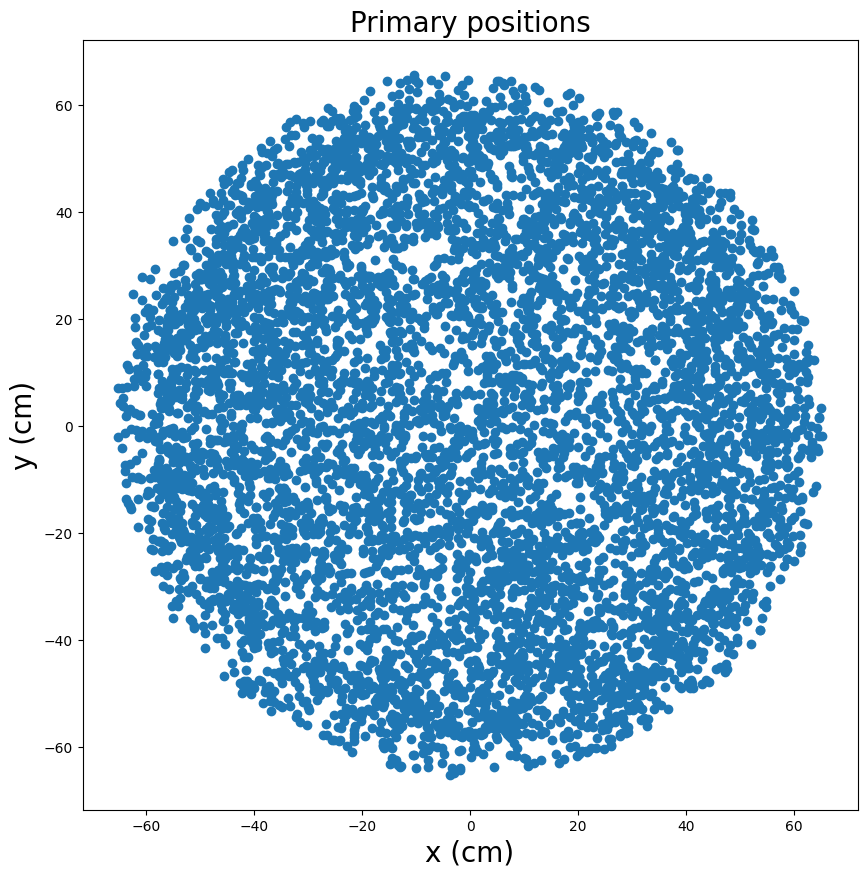

In [4]:
f = plt.figure(figsize=(10,10))
plt.scatter(primaries['primary_x'],primaries['primary_y'])#, bins=100, norm=LogNorm())
plt.xlabel('x (cm)', fontsize=20)
plt.ylabel('y (cm)', fontsize=20)
plt.title('Primary positions', fontsize=20)
#plt.colorbar()
plt.show()

## Simulated position distribution 

In [5]:
def simulate_lonehits(size, rate = 5e3+10, PMT_range=(0, 493)):
    dt = (1 / rate) * np.ones(size - 1)
    times = np.append([1.0], 1.0 + dt.cumsum()) * 1e9 #time in ns
    times = times.round().astype(np.int64)
    filtered_indices = PMT_position.index[PMT_position.index.isin(lonehit_channels)]
    PMT_indices = np.random.choice(filtered_indices, size=size)
    df = pd.DataFrame({
        'x': PMT_position.iloc[PMT_indices]['x'].values,
        'y': PMT_position.iloc[PMT_indices]['y'].values,
        'array': PMT_position.iloc[PMT_indices]['array'].values,
        'times': times
    })
    return df

In [6]:
df_lonehit = simulate_lonehits(10000)

In [7]:
len_y = len(df_lonehit)
len_prim = len(primaries)
x_prim = primaries['primary_x'].values
y_prim = primaries['primary_y'].values
del result, primaries
@njit
def dis(x,y):
    d2 = []
    for i in range(len_prim):
        for j in range(len_y):
            d2.append((x_prim[i] - x[j])**2 + (y_prim[i]-y[j])**2)
    return d2

In [8]:
%%time
d2 = dis(df_lonehit['x'].values,df_lonehit['y'].values)
d = np.sqrt(d2)

CPU times: user 3.82 s, sys: 1.25 s, total: 5.08 s
Wall time: 5.13 s


### How would distributions look if we take differences in points uniformly distributed?

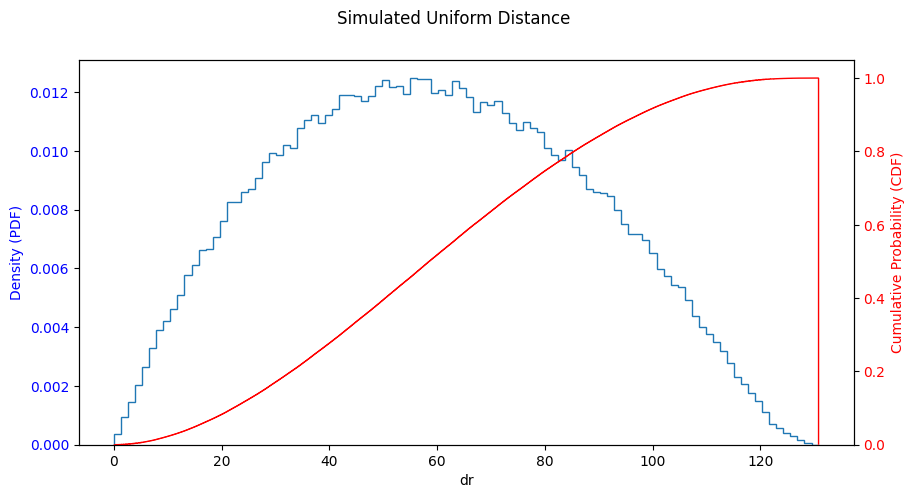

In [9]:
fig, ax1 = plt.subplots(figsize=(10, 5))
# Remove elements where d == 0
d = d[d != 0]
# Plot PDF
ax1.hist(d, bins=100, histtype='step', density=True)
ax1.set_xlabel("dr")
ax1.set_ylabel('Density (PDF)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot CDF on the secondary y-axis
ax2 = ax1.twinx()
ax2.hist(d, bins=1000, histtype='step', color='r', cumulative=True, density=True)
ax2.set_ylabel('Cumulative Probability (CDF)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
fig.suptitle('Simulated Uniform Distance')
plt.show()


In [10]:
np.isnan(d).any()

False

In [11]:
#pdf
d_hist, d_bins = np.histogram(d, bins=np.linspace(0,max(d),10000))
#cdf
corrdinate_transofmration_histogram = np.cumsum(d_hist)/max(np.cumsum(d_hist))


In [12]:
d_twiddle_simulated_bottom = []
for r_old in tqdm(d):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_simulated_bottom.append(corrdinate_transofmration_histogram[location])


100%|██████████| 74330000/74330000 [10:41<00:00, 115850.31it/s]


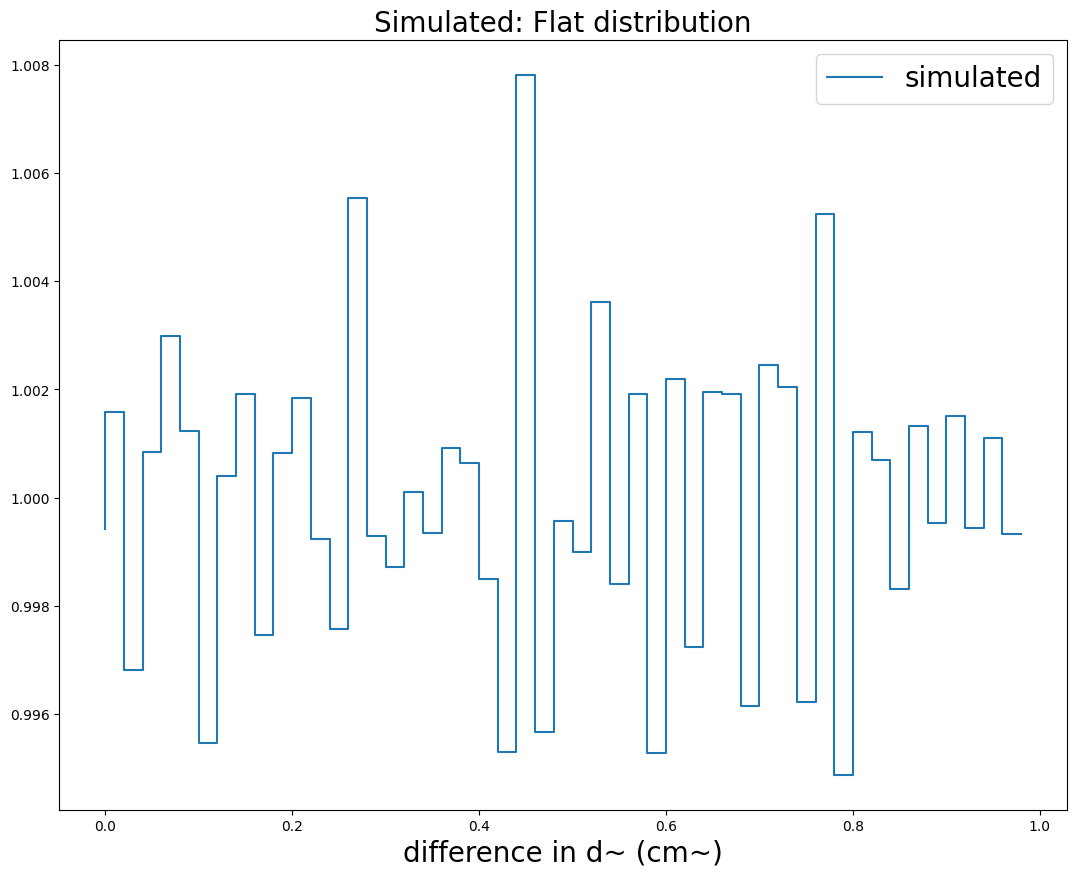

In [19]:
plt.figure(figsize=(13,10))
hist_dsb, bins_dsb = np.histogram(d_twiddle_simulated_bottom, bins=50, density=True)
plt.plot(bins_dsb[:-1], hist_dsb, drawstyle='steps', label='simulated')
plt.xlabel('difference in d~ (cm~)', fontsize=20)
plt.title('Simulated: Flat distribution', fontsize=20)
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.ylim(0,100)
plt.show()

## Observed position distribution

In [16]:
result_bottom['dr'] = np.sqrt((result_bottom['x']-result_bottom['primary_x'])**2+(result_bottom['y']-result_bottom['primary_y'])**2)

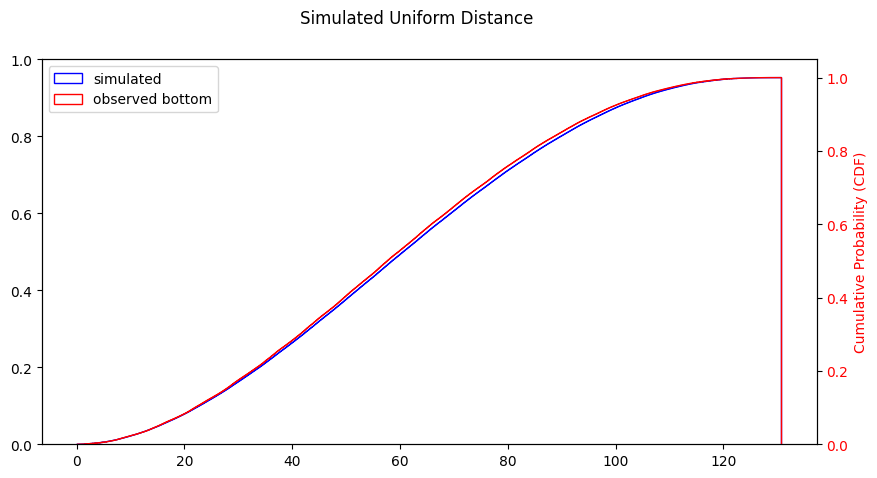

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 5))
# Remove elements where d == 0
d = d[d != 0]

# Plot CDF on the secondary y-axis
ax2 = ax1.twinx()
ax2.hist(d, bins=1000, histtype='step', color='b', cumulative=True, density=True,label='simulated')
ax2.hist(result_bottom['dr'], bins=1000, histtype='step', color='r', cumulative=True, density=True,label='observed bottom')
ax2.set_ylabel('Cumulative Probability (CDF)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.legend()
# Add title and legend
fig.suptitle('Simulated Uniform Distance')
plt.show()


In [18]:
d_twiddle_observed_bottom = []
for r_old in tqdm(result_bottom['dr']):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_observed_bottom.append(corrdinate_transofmration_histogram[location])

100%|██████████| 11703023/11703023 [01:43<00:00, 113009.53it/s]


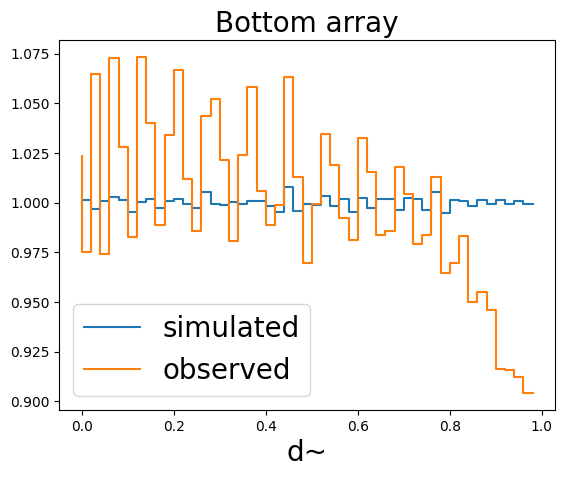

In [40]:
plt.plot(bins_dsb[:-1], hist_dsb, drawstyle='steps', label='simulated')
hist_dob, bins_dob = np.histogram(d_twiddle_observed_bottom, bins=50, density=True)
plt.plot(bins_dob[:-1], hist_dob, drawstyle='steps', label='observed')
plt.xlabel('d~', fontsize=20)
plt.title('Bottom array', fontsize=20)
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.ylim(0,100)
plt.show()

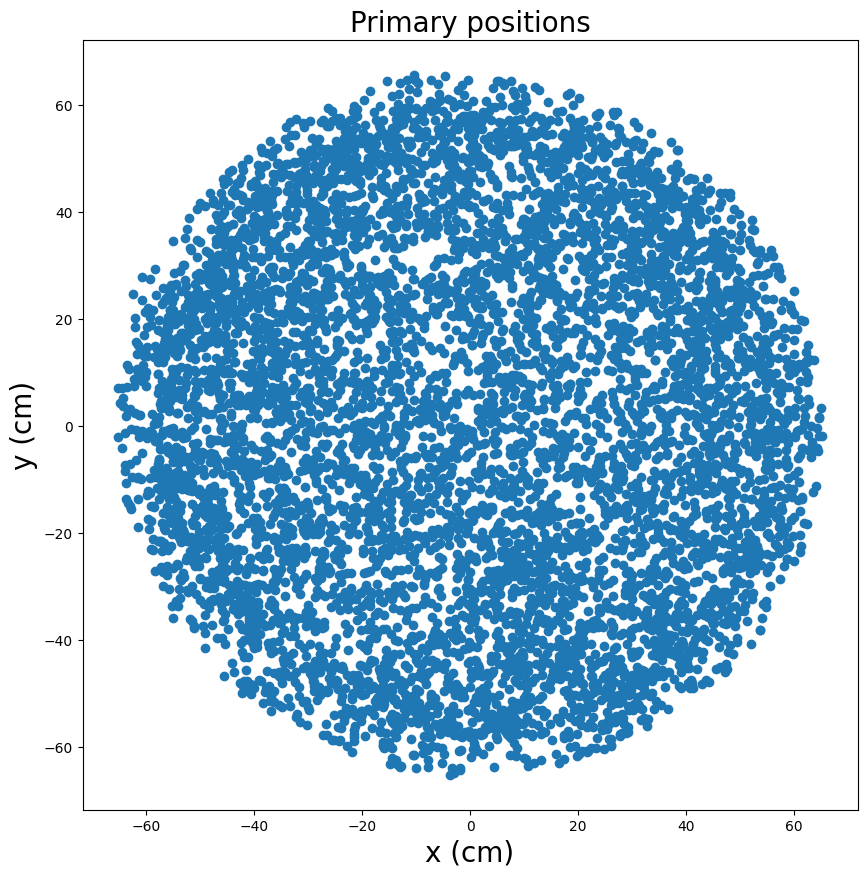

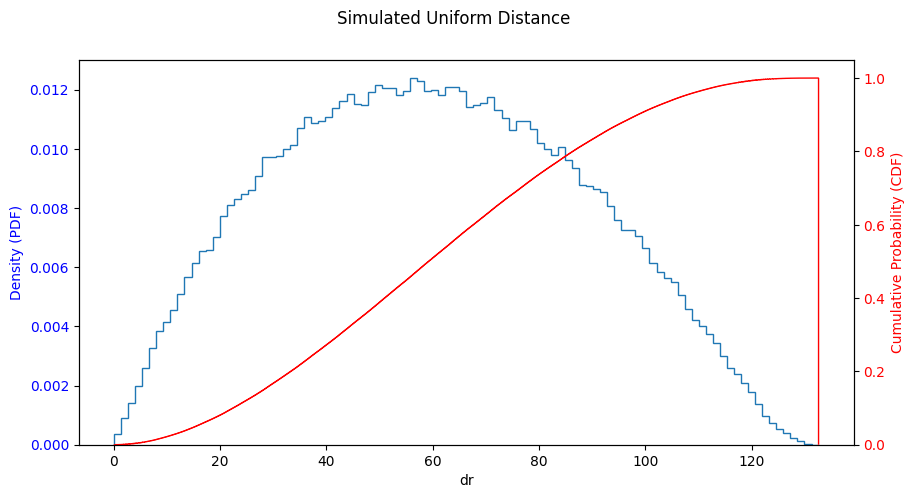

100%|██████████| 74330000/74330000 [10:53<00:00, 113725.56it/s]


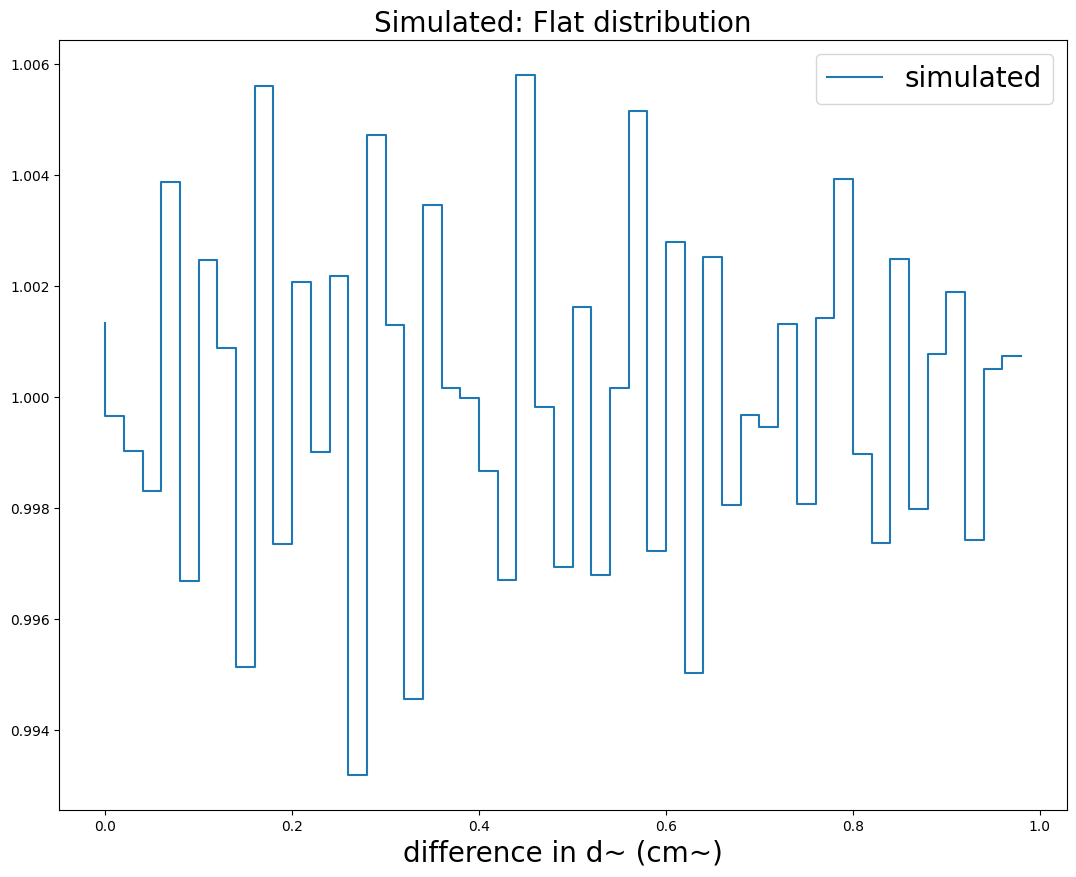

In [34]:
result_top = result[result['array']=='top'].reset_index(drop=True)
primaries = result_top.drop_duplicates(subset=['primary_position'])
lonehit_channels = result_top['lone_hit_channel'].unique()
f = plt.figure(figsize=(10,10))
plt.scatter(primaries['primary_x'],primaries['primary_y'])#, bins=100, norm=LogNorm())
plt.xlabel('x (cm)', fontsize=20)
plt.ylabel('y (cm)', fontsize=20)
plt.title('Primary positions', fontsize=20)
#plt.colorbar()
plt.show()
df_lonehit = simulate_lonehits(10000)
len_y = len(df_lonehit)
len_prim = len(primaries)
x_prim = primaries['primary_x'].values
y_prim = primaries['primary_y'].values
del result, primaries
d2 = dis(df_lonehit['x'].values,df_lonehit['y'].values)
d = np.sqrt(d2)
fig, ax1 = plt.subplots(figsize=(10, 5))
# Remove elements where d == 0
d = d[d != 0]
# Plot PDF
ax1.hist(d, bins=100, histtype='step', density=True)
ax1.set_xlabel("dr")
ax1.set_ylabel('Density (PDF)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot CDF on the secondary y-axis
ax2 = ax1.twinx()
ax2.hist(d, bins=1000, histtype='step', color='r', cumulative=True, density=True)
ax2.set_ylabel('Cumulative Probability (CDF)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add title and legend
fig.suptitle('Simulated Uniform Distance')
plt.show()
np.isnan(d).any()
#pdf
d_hist, d_bins = np.histogram(d, bins=np.linspace(0,max(d),10000))
#cdf
corrdinate_transofmration_histogram = np.cumsum(d_hist)/max(np.cumsum(d_hist))
d_twiddle_simulated_top= []
for r_old in tqdm(d):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_simulated_top.append(corrdinate_transofmration_histogram[location])
plt.figure(figsize=(13,10))
hist_dst, bins_dst = np.histogram(d_twiddle_simulated_top, bins=50, density=True)
plt.plot(bins_dst[:-1], hist_dst, drawstyle='steps', label='simulated')
plt.xlabel('difference in d~ (cm~)', fontsize=20)
plt.title('Simulated: Flat distribution', fontsize=20)
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.ylim(0,100)
plt.show()

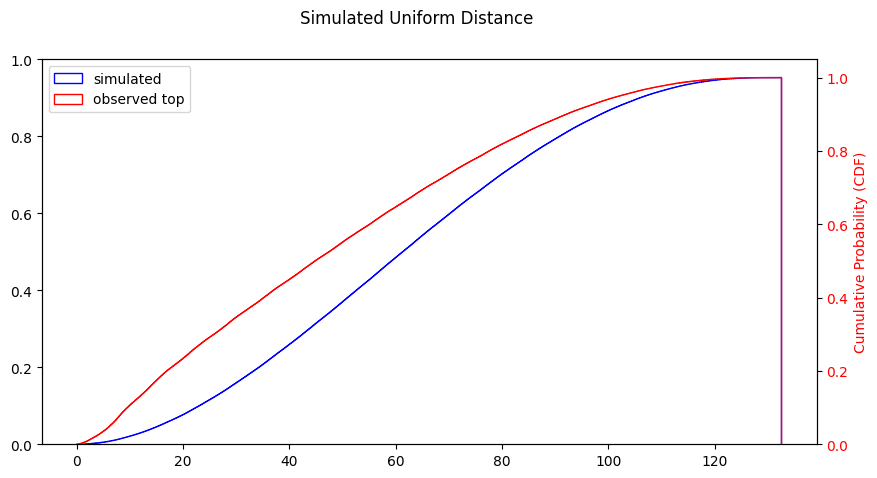

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 5))
# Remove elements where d == 0
d = d[d != 0]

# Plot CDF on the secondary y-axis
ax2 = ax1.twinx()
ax2.hist(d, bins=1000, histtype='step', color='b', cumulative=True, density=True,label='simulated')
result_top['dr'] = np.sqrt((result_top['x']-result_top['primary_x'])**2+(result_top['y']-result_top['primary_y'])**2)
ax2.hist(result_top['dr'], bins=1000, histtype='step', color='r', cumulative=True, density=True,label='observed top')
ax2.set_ylabel('Cumulative Probability (CDF)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.legend()
# Add title and legend
fig.suptitle('Simulated Uniform Distance')
plt.show()

In [38]:
d_twiddle_observed_top = []
for r_old in tqdm(result_top['dr']):
    location = np.argmin(abs(d_bins[1:]-r_old))
    d_twiddle_observed_top.append(corrdinate_transofmration_histogram[location])

100%|██████████| 8988326/8988326 [01:26<00:00, 103806.16it/s]


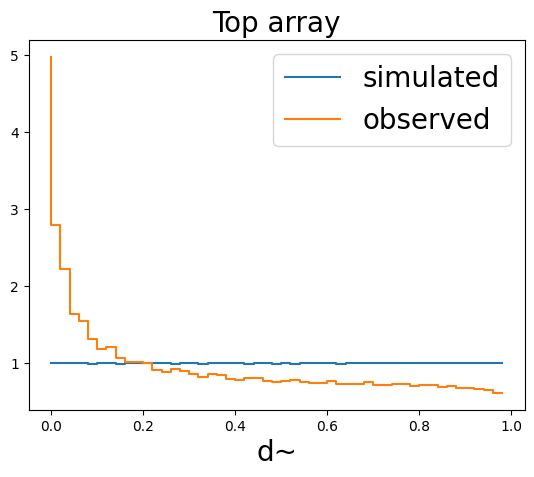

In [41]:
plt.plot(bins_dst[:-1], hist_dst, drawstyle='steps', label='simulated')
hist_dot, bins_dot = np.histogram(d_twiddle_observed_top, bins=50, density=True)
plt.plot(bins_dot[:-1], hist_dot, drawstyle='steps', label='observed')
plt.xlabel('d~', fontsize=20)
plt.title('Top array', fontsize=20)
plt.legend(fontsize=20)
#plt.yscale('log')
#plt.ylim(0,100)
plt.show()